In [1]:
#!/usr/bin/env python3
#import your libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_train = train_transaction.merge(train_identity, on='TransactionID', how='left')

In [3]:
train_transaction.shape[0]/2

295270.0

In [4]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
# train_transaction.info();

In [7]:
# train_identity.info();

In [8]:
train_transaction_sum = train_transaction.duplicated().sum()
train_identity_sum = train_identity.duplicated().sum()
columns = train_transaction.columns
print('Train transaction duplicates: {}\nTrain identity duplicates: {} \n'.format(train_transaction_sum, train_identity_sum))
# print('Train feature columns:\n', list(columns))

Train transaction duplicates: 0
Train identity duplicates: 0 



In [9]:
# print(train_transaction.shape)
# print(train_identity.shape)

In [10]:
# df_train.shape

In [11]:
# # print(df_train.shape)
# df_fraud = df_train[df_train['isFraud']==1]
# df_no_fraud = df_train[df_train['isFraud']==0]
# print(df_fraud.shape)
# print(df_no_fraud.shape)
# # do we have more information for folks who end up having fraud issues?

In [12]:
# list_fraud = np.sum(df_fraud.isnull())
# list_nofraud = np.sum(df_no_fraud.isnull())

In [13]:
# print(sum(np.sum(df_fraud.isnull())))
# print(sum(np.sum(df_no_fraud.isnull())))

In [14]:
# # What are total null values of each...?
# df_fraud.shape[0]/sum(np.sum(df_fraud.isnull()))

In [15]:
# df_no_fraud.shape[0]/sum(np.sum(df_no_fraud.isnull()))

In [16]:
# determine what features we can drop due to too many missing features
# list_notnull = df_fraud[(df_fraud.isnull())].index
# df_fraud.loc[list_notnull,:]

In [17]:
# df_null = pd.DataFrame(np.sum(df_train.isnull()), columns=['total']).reset_index()

### Assigning columns to specific lists (cat, num, date, etc.)

In [18]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

In [19]:
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]

In [20]:
# D = time elapsed between each transaction, card = card information, C = counting, ie how many addresses 
# associated with card, M=True/False, V created features on ranking, counting, etc. 

# column id and target
col_id = ['TransactionID']
col_target = ['isFraud']

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# boolean columns. convert via dummy variable. We dont know if true/false is better than one or the other. 
col_bool = col_m

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_bool + col_id + col_i + col_target)))

# col_all = col_cat + col_num + col_date + col_bool + col_id + col_target
# columns removed dist1, dist2, R_emaildomain, DeviceInfo, DeviceType

Total columns: 220


### Filling In Missing Values

In [21]:
# 295270 50%

In [22]:
# len(df_train['P_emaildomain'].unique())

In [23]:
# df_train[val].dtype=='O'
# len(df_train['D3'].unique())
# np.sum(df_train['card4'].isnull())

In [24]:
# df_train.columns
# print(df_train['card4'].dtype)
# len(df_train['card4'].unique())
# df_train['card4'].dtype
# df_train['D1'].unique()
# df_train['card1'].dtype=='O'
# val_temp = (df_train['card1'].dtype=='O')
# val_temp = df_train['card1'].dtype
# val_temp
# isinstance(df_train['D1'], object)
# df_train['card1'].unique().shape 
# val_len = len(df_train['card1'].unique())
# val_len

# np.sum(df_train['D1'].isnull())
# we need to confirm that 195 columns do in fact have null values before proceeding..then we can get the unique
# col value types, then we can begin imputing missing values with the mode values... 

# checking to see how many columns have null values. 195. 
list_temp = []
list_col = []
for val in df_train.columns:
    calc_ = np.sum(df_train[val].isnull())
    list_temp.append(calc_)
    list_col.append(val)
# list_temp

# df_temp = pd.DataFrame([list_temp,list_col], columns=['total','col'])
# df_temp


In [299]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.list_col = []
        self.list_total = [] 
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                
                self.list_mode_value.append(df_train[val].mode()[0])
                self.list_mode_count.append(max(df_train[val].value_counts()))
                self.list_mode_count_perc.append(max(df_train[val].value_counts())/len(df_train))
                
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):                  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if (len(val_unique) < 100):
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index().rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info

pp = Preprocessing()
df_null_info = pp.missing_values()
df_null_info
# determine what to do with columns that have too many unique values... obviously.. types of solutions
# would be to put "MISSING" for those that dont have an email address... but you will need to evaluate 
# and make instead a counter of unique values, then append that and look at the CSV via google sheets. use 
# something like the code below 

# Planning - our preprocessing method must automatically drop missing values, but we can't do that because
# we need to see about filling them in first, then decide if we need to drop them. Right now, we need to
# create a dataframe that shows unique values for each column with missing values. 

# we need to look at each variable and see if it's unique or categorical. We need to use possibly PCA...? How do
# we handle so many variables? 

,col_name,total_null,datatype,total_unique,mode_value,mode_count,mode_percentage,unique
0,card4,1577,object,5,visa,384767,0.651551,"[discover, mastercard, visa, american express,..."
1,card6,1571,object,5,debit,439938,0.744976,"[credit, debit, nan, debit or credit, charge c..."
2,P_emaildomain,94456,object,60,gmail.com,228355,0.386688,"[nan, gmail.com, outlook.com, yahoo.com, mail...."
3,D1,1269,float64,642,0,280130,0.474362,0
4,D2,280797,float64,642,0,15124,0.025610,0
...,...,...,...,...,...,...,...,...
190,V317,12,float64,15185,0,519413,0.879556,0
191,V318,12,float64,12310,0,535074,0.906076,0
192,V319,12,float64,4800,0,562740,0.952924,0
193,V320,12,float64,6440,0,542892,0.919315,0


In [46]:
np.sum(df_train.isnull().any(axis=1))

513110

In [31]:
# df_train['isFraud'].unique().shape

In [32]:
# plt.bar(df_train['V14'])
# sns.barplot(df_train['V196'])
# we need to imput the mode here.. 
# df_train['V14'].mode()
# df_train['V22'].unique()
# for val in col_v:
#     print(val)
#     print(df_train[val].unique())
# we ned to descern what is a 0 1 outcome then impute.

In [167]:
# 0. We have dropped unnecessary rows
# 1. determine how we will fillna
# 2. determine how we will impute the columns. Determine which might be continuous
# 3. Ranking stay the same.. categorical need to be one hot encoded.. or ohe may not make a difference..

In [122]:
mode = ['card4','card6','P_emaildomain','D1','D2','D3','D4', 'D10', 'D11', 'D15',
       'M1','M2','M3','M4', 'M6','V1','V2','V3','V4','V5','V6','V7','V8','V9','',]

Missing values: 12
REAL VALUE COUNTS: 


1.0    551866
2.0     30249
3.0      4936
4.0      1672
5.0       681
Name: V290, dtype: int64

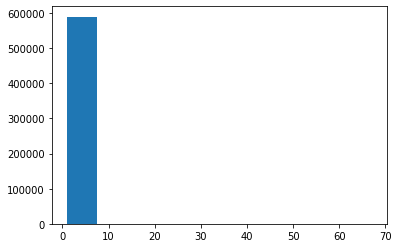

In [290]:
# col = 'D15'
# series_temp = df_train[col].fillna(0)
# plt.hist(series_temp);
# df_train[col].value_counts()

col = 'V290'
series_temp = df_train[col].fillna(df_train[col].mode()[0])
plt.hist(series_temp);
missing_val = np.sum(df_train[col].isnull())
print('Missing values: ' + str(missing_val))
print("REAL VALUE COUNTS: ")
df_train[col].value_counts().head()

In [297]:
list_mode_count = []
list_mode_value = []
list_mode_count_percentage = []

for val in df_null_info['col_name']:
    list_mode_value.append(df_train[val].mode()[0])
    list_mode_count.append(max(df_train[val].value_counts()))
    list_mode_count_percentage.append(max(df_train[val].value_counts())/len(df_train))

mode_value = pd.Series(list_mode_value, name='mode_value')
mode_count = pd.Series(list_mode_count, name='mode_count')
mode_count_percentage = pd.Series(list_mode_count_percentage, name='mode_percentage')
pd.concat([mode_value, mode_count, mode_count_percentage], axis=1)

,mode_value,mode_count,mode_percentage
0,visa,384767,0.651551
1,debit,439938,0.744976
2,gmail.com,228355,0.386688
3,0,280130,0.474362
4,0,15124,0.025610
...,...,...,...
190,0,519413,0.879556
191,0,535074,0.906076
192,0,562740,0.952924
193,0,542892,0.919315


M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64

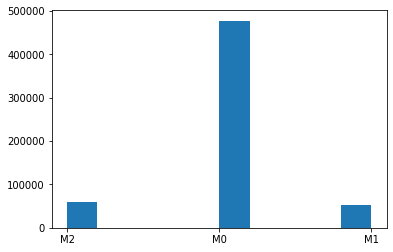

In [117]:
col = 'card4'
series_temp = df_train[col].fillna(df_train[col].mode()[0])
plt.hist(series_temp);
df_train[col].value_counts()

0.0      280130
1.0        8634
2.0        4969
3.0        3954
4.0        3570
          ...  
621.0       109
619.0       107
638.0        79
639.0        42
640.0        14
Name: D1, Length: 641, dtype: int64

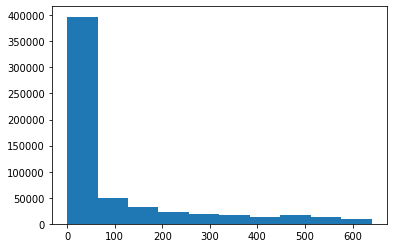

In [104]:
col = 'D1'
series_temp = df_train[col].fillna(df_train[col].mean())
plt.hist(series_temp);
df_train['D1'].value_counts()

In [67]:
# list_temp = df_train['card4']
# plt.hist(list_temp)
# df_train['card4'].nunique()
# for val in df_train['card4'].unique():
#     total_values = df_train[df_train['card4']==val].shape[0]
#     print(val)
#     print(total_values)
    
np.sum(df_train['card4'].isnull())

1577

0          13.0
9          30.0
12         11.0
13         10.0
19          2.0
          ...  
590525     15.0
590527      6.0
590532    315.0
590533      6.0
590535     30.0
Name: D3, Length: 233310, dtype: float64

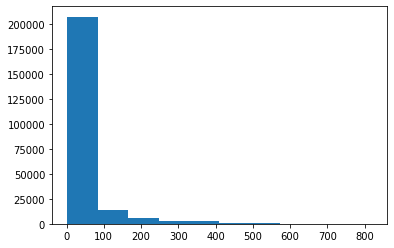

In [33]:
list_temp = df_train[df_train['D3']>1]['D3']
plt.hist(list_temp)
list_temp
# NEXT, determine which columns have decimal values that are not. 
# Can we convert deciminal numbers to floating numbers...? Can we convert a column to astype int?lets see 
# what happens if we try that... 

In [34]:
# # df_train['V307'].astype(int)

# list_v307_test = df_train['V307'].fillna(df_train['V307'].mode())

# list_v307_test.astype(int)

In [35]:
# list_v22_test = df_train['V22'].fillna(df_train['V22'].mode)
# # df_train['V22'].unique()
# list_v22_test
# # df_train['V22']
# # df_train['V22']


(array([2.49000e+02, 5.87242e+05, 2.56600e+03, 0.00000e+00, 1.22000e+02,
        3.50000e+01, 0.00000e+00, 7.00000e+00, 1.00000e+00, 4.00000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

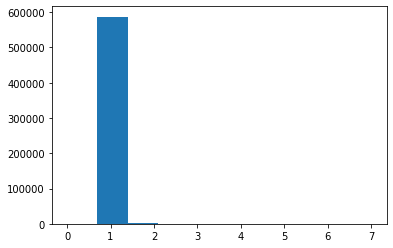

In [36]:
list_temp = df_train['V108']
df_train['V108'].unique()
plt.hist(list_temp)

(array([478., 175., 187., 168.,  88.,  87.,  87., 127.,  87.,  87.]),
 array([ 11. ,  97.9, 184.8, 271.7, 358.6, 445.5, 532.4, 619.3, 706.2,
        793.1, 880. ]),
 <a list of 10 Patch objects>)

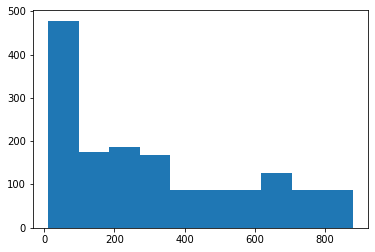

In [37]:
# we need to figure out which column is counting, which is ranking.. That's a lot of work...
# Can we just fillna 0 for counting with mode...? Or should we use 0..? Mode is appropriate. 
# CAn we fillna for ranking with 0... or fillna with mode... Mode would be appropriate. 
# Are V values supposed to be numerial or object..
# 1. Fillna for v values with mode 
# 2. Are V values supposed to be numerical or objects? 
# 3. Can we descern a counter versus ranking from a dist plot..? 
# 4. We discern categorical easily 
# 5. Can we descrne what's continuous? If so, use mean value
# mean filna - for continuous 
# mode fillna - ranking, categorical, True/False
# Should we drop certain rows? 
# Which is a counter and which is a category? We need to look at the distributions to answer this. 
# We need to clean the data before thinking about applying PCA. 
# 1. Determine which columns are continuous, which are ranking.
# 2. Determine which columns are bool (easy)
# 3. Determine which columns are categorical, then impute with pandas (we dont know which columns means what
#    so we cant assume True or better than False, etc.)
# 4. After 

list_temp = df_train[df_train['V95']>10]['V95']
list_temp
plt.hist(list_temp)

In [38]:
# list_temp

In [39]:
# df_null_total.sort_values('total_null', ascending=False)
# np.sum(df_train['card4'].isnull())

In [40]:
# sns.distplot(df_train['V1'])

In [41]:
# print(pd.DataFrame(df_train[col_num].dtypes).reset_index())
# for val in col_num:
#     val_dtype = df_train[val].dtypes
# #     print(val)
# #     print(df_train[val][0])
#     print(str(val_dtype))
# # NEXT, ensure col num and actual values look correct. 
# df_train[col_cat].dtypes
# pd.DataFrame(np.sum(train_df.isnull())).reset_index().to_csv('fraud_detection_null.csv')

In [42]:
# # dropping columns with more than 50% missing data automatically.
# length_df = df_train.shape[0]/2
# list_temp = []
# for val in df_train.columns:
#     if np.sum(df_train[val].isnull()) > length_df:
#         list_temp.append(val)   
# df_train = df_train.drop(list_temp, axis=1)

In [43]:
# list(df_train.columns)